In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
import missingno as msno
import seaborn as sns
import numpy as np


sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Exploratory Data Analysis

The data were provided by Mia Lieberman (DCM), for her project on testing the efficacy of a variety of smartphone sanitization methods.

In [2]:
data = pd.read_csv('smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])

Let's take a quick look at her data matrix.

In [3]:
data.head()

,sample_id,treatment,colonies_pre,colonies_post,perc_reduction colonies,morphologies_pre,morphologies_post,year,month,day,perc_reduction morph,site,phone ID,no case,screen protector
0,1,phonesoap,0,0,NaN,0,0,2015.0,10.0,7.0,NaN,phone,4,NaN,NaN
1,2,phonesoap,12,0,100.000000,3,0,2015.0,10.0,7.0,100.0,junction,4,NaN,NaN
2,3,phonesoap,14,4,71.428571,5,2,2015.0,10.0,7.0,60.0,case,4,NaN,NaN
3,4,ethanol,0,0,NaN,0,0,2016.0,4.0,20.0,NaN,phone,4,NaN,NaN
4,5,ethanol,0,1,NaN,0,1,2016.0,4.0,20.0,NaN,junction,4,NaN,NaN


In [4]:
data.columns

Index(['sample_id', 'treatment', 'colonies_pre', 'colonies_post',
       'perc_reduction colonies', 'morphologies_pre', 'morphologies_post',
       'year', 'month', 'day', 'perc_reduction morph', 'site', 'phone ID',
       'no case', 'screen protector'],
      dtype='object')

In [5]:
set(data['treatment'].values)

{'CB30',
 'FBM_2',
 'bleachwipe',
 'cellblaster',
 'ethanol',
 'kimwipe',
 'phonesoap',
 'quatricide'}

It's apparent that Mia is an excellent data curator! It's a flat file, with each row being one observation, and the raw data, derivative data, and metadata are all stored.

Before we continue on analyzing the data, let's quickly check the data for completeness.

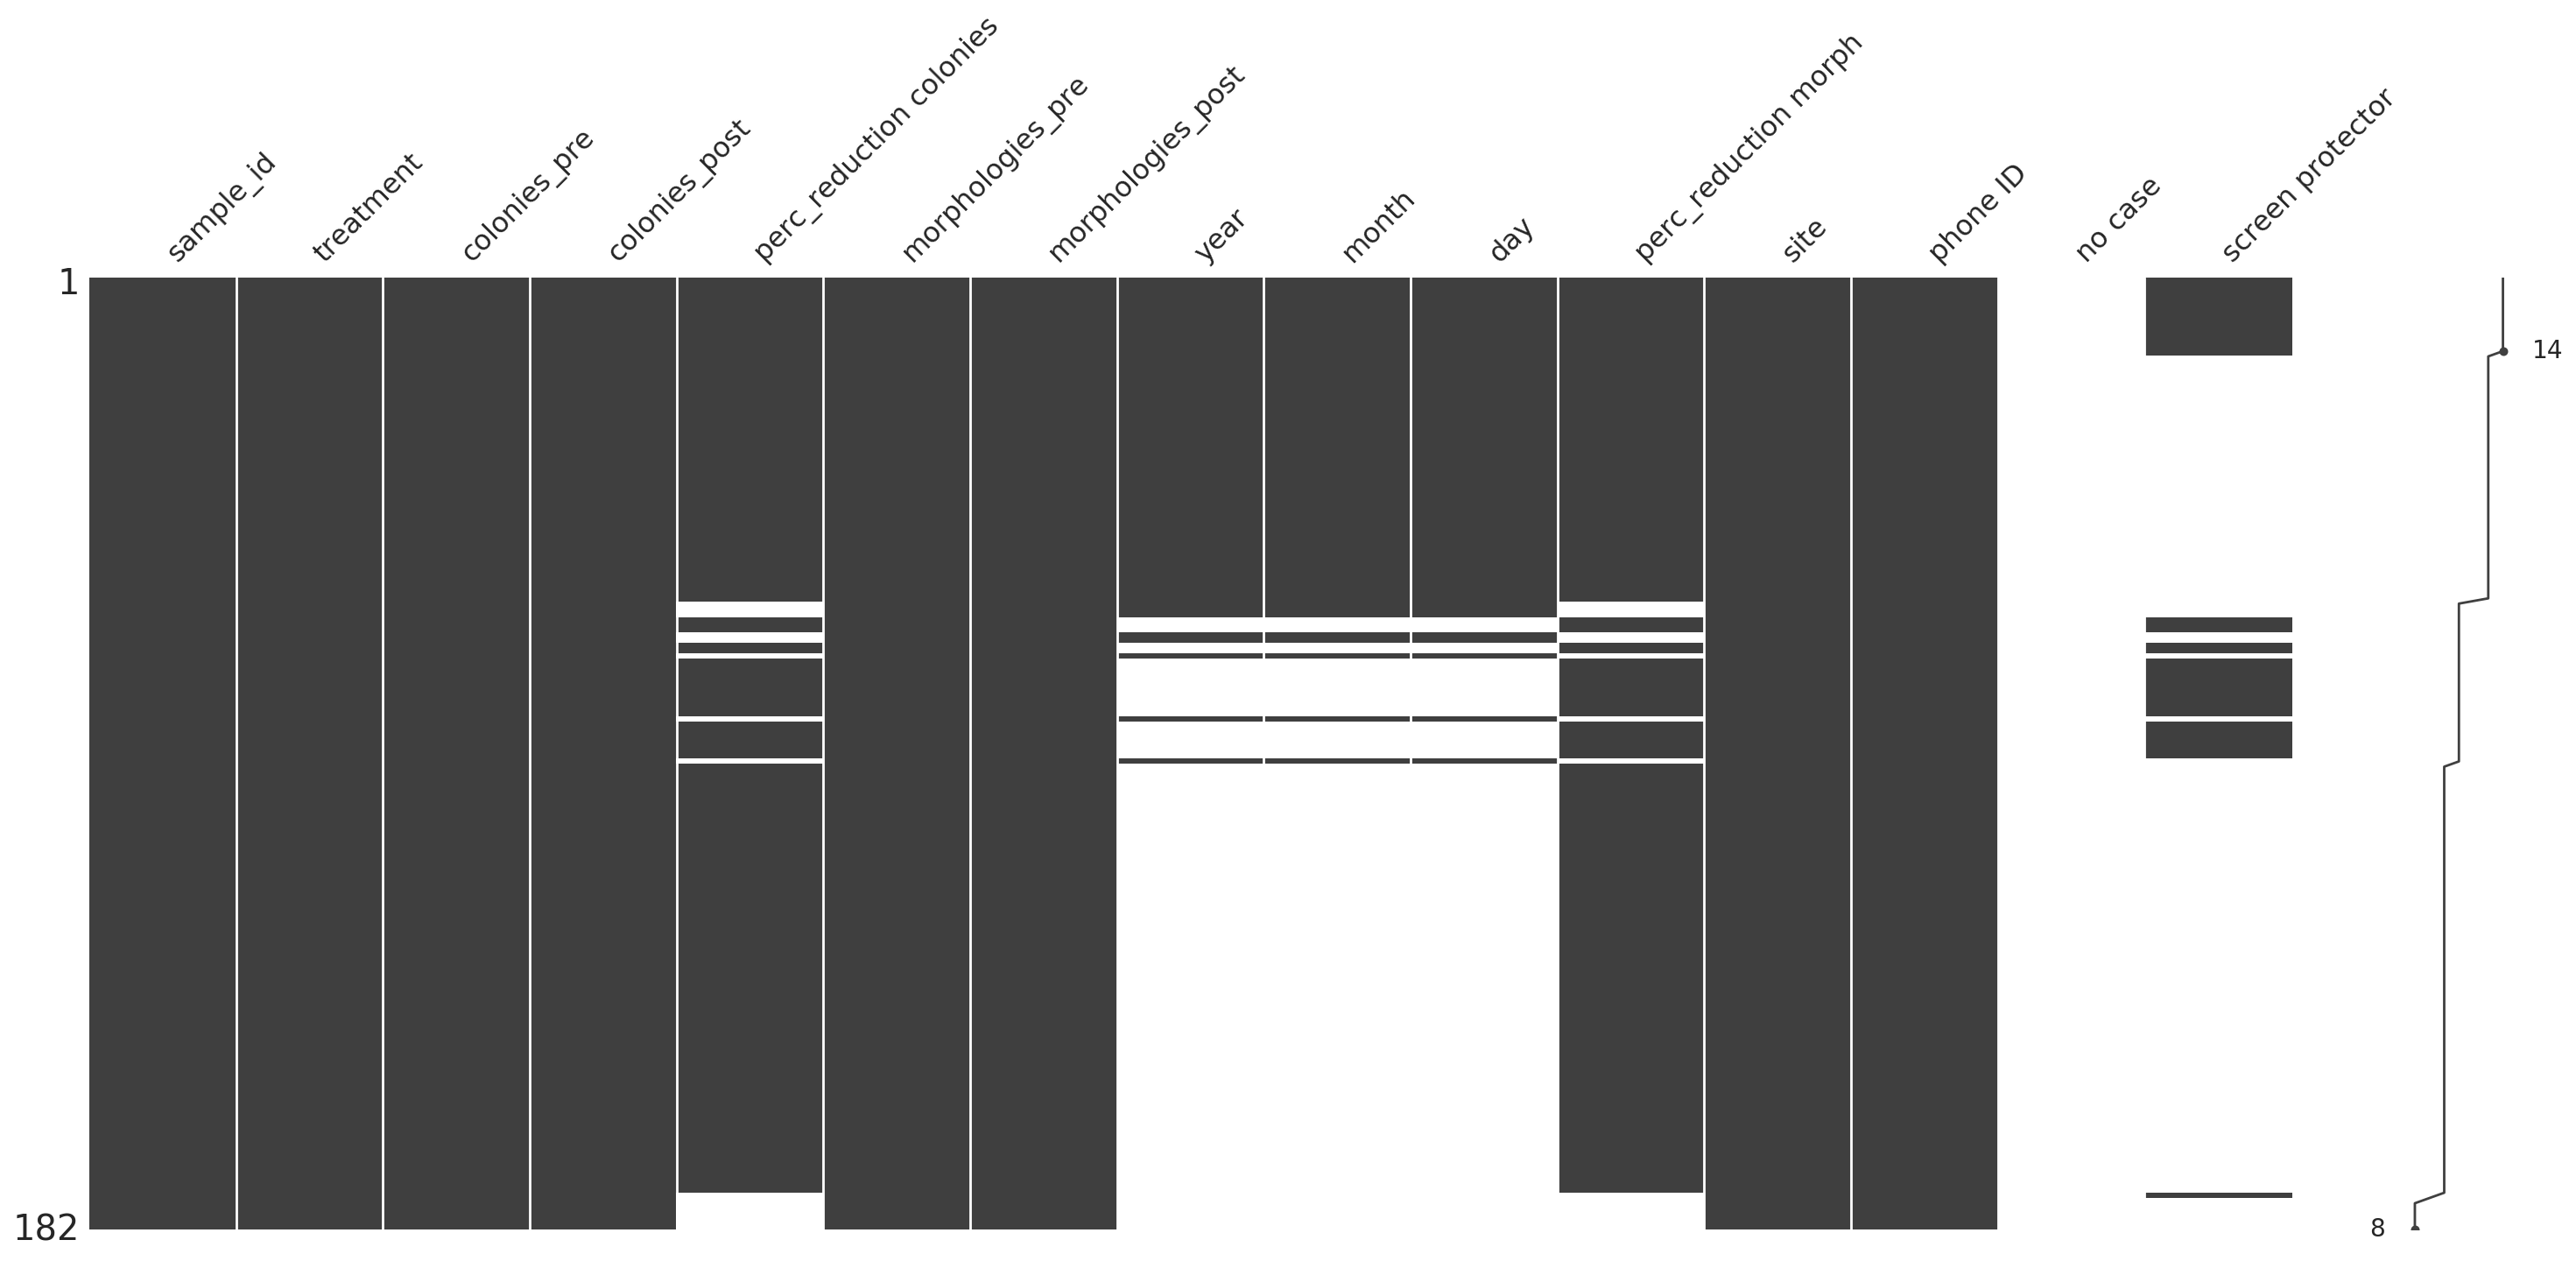

In [7]:
sorted_data = msno.nullity_sort(data, sort='descending')
fig = msno.matrix(sorted_data, inline=False)
plt.savefig('data-completeness.pdf', bbox_inches='tight', dpi=300)

It's clear here that not every row of data has the year/month/day information recorded. On the other hand, the columns that I expected her to have complete data (`colonies_pre`, `colonies_post`, `morphologies_pre`, `morphologies_post`) are all present.

Just to get a feel for her data, let's look at the mean pre- and post-treatment CFU for each treatment method, and see if it matches what she has in her slides.

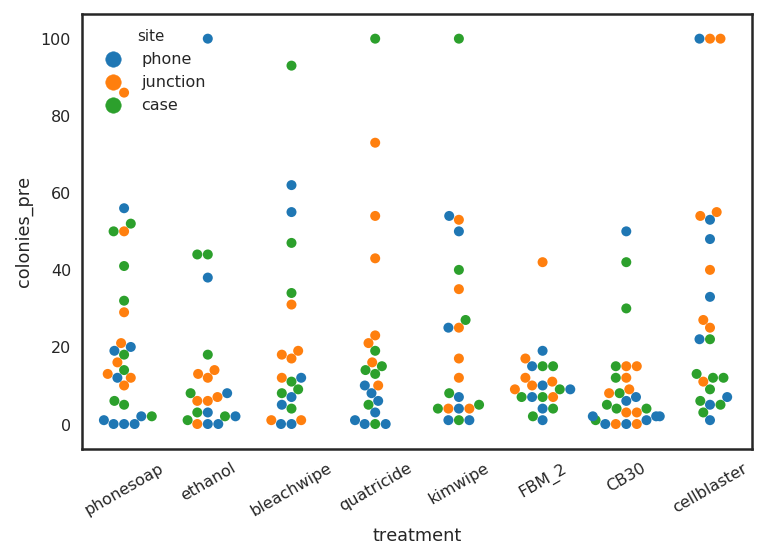

In [8]:
# data.groupby('treatment').mean().plot(kind='bar', y=['colonies_pre', 'colonies_post'], yerr=data.groupby('treatment').std())
fig = sns.swarmplot(data=data, x='treatment', y='colonies_pre', hue='site')
plt.xticks(rotation=30)
plt.show()

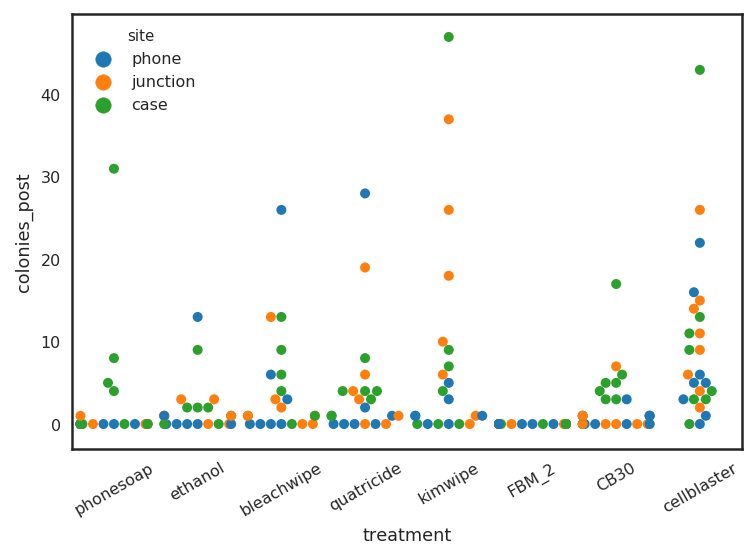

In [9]:
fig = sns.swarmplot(data=data, x='treatment', y='colonies_post', hue='site')
plt.xticks(rotation=30)
plt.show()

Indeed it does; good sanity check.

Update 23 February 2017: CB-30 data are going to be excluded from the final analyses. Therefore, drop them from the table.

Mia's data involves a number of rows where zeroes are divided by other zeroes in order to compute the percentage reduction in colonies. (Phones with zero colonies can show up by random chance, given the sampling strategy, so they should not be excluded.) I think there might be a more principled way to go about this, so that we don't have to end up ignoring the data where no colonies were found (because of division by zero).

Colonies are discrete count data. We can probably use a Poisson likelihood for `colonies_pre` and `colonies_post` in a Bayesian framework, and then use that to estimate the reduction percentage with uncertainty. In doing so, there's no need to worry about p-values and the likes.

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
renamed_treatments = dict()
renamed_treatments['FBM_2'] = 'FBM120'
renamed_treatments['bleachwipe'] = 'BW'
renamed_treatments['ethanol'] = 'ET'
renamed_treatments['kimwipe'] = 'KW'
renamed_treatments['phonesoap'] = 'PS300'
renamed_treatments['quatricide'] = 'QA'
renamed_treatments

{'FBM_2': 'FBM120',
 'bleachwipe': 'BW',
 'ethanol': 'ET',
 'kimwipe': 'KW',
 'phonesoap': 'PS300',
 'quatricide': 'QA'}

In [16]:
# Reload the data one more time.
data = pd.read_csv('smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])
del data['perc_reduction colonies']

# Exclude cellblaster data
data = data[data['treatment'] != 'CB30']
data = data[data['treatment'] != 'cellblaster']

# Rename treatments
data['treatment'] = data['treatment'].apply(lambda x: renamed_treatments[x])

# Sort the data according to the treatments.
treatment_order = ['PS300', 'FBM120', 'BW', 'ET', 'QA', 'KW']
data['treatment'] = data['treatment'].astype('category')
data['treatment'].cat.set_categories(treatment_order, inplace=True)
data = data.sort_values(['treatment']).reset_index(drop=True)

# Encode the treatment index.
data['treatment_idx'] = data['treatment'].apply(lambda x: treatment_order.index(x))
data['perc_change_colonies'] = (data['colonies_post'] - data['colonies_pre']) / data['colonies_pre']

# View the first 5 rows.
data.head(5)

,sample_id,treatment,colonies_pre,colonies_post,morphologies_pre,morphologies_post,year,month,day,perc_reduction morph,site,phone ID,no case,screen protector,treatment_idx,perc_change_colonies
0,1,PS300,0,0,0,0,2015.0,10.0,7.0,NaN,phone,4,NaN,NaN,0,NaN
1,59,PS300,18,0,4,0,NaN,NaN,NaN,100.0,case,21,NaN,NaN,0,-1.0
2,101,PS300,5,0,3,0,2016.0,5.0,10.0,100.0,case,3,NaN,NaN,0,-1.0
3,100,PS300,86,0,4,0,2016.0,5.0,10.0,100.0,junction,3,NaN,NaN,0,-1.0
4,99,PS300,56,0,3,0,2016.0,5.0,10.0,100.0,phone,3,NaN,NaN,0,-1.0


Because we are modelling the count data using a Poisson distribution, we need a non-informative prior to be placed on the Poisson rate parameter $\mu_{pre}$ and $\mu_{post}$. Because we are dealing with discrete count data, we will use the Discrete Uniform prior, with a wide range from 0 to 1000, for each of the pre- and post-treatment colony counts.

Finally, to compute the percentage reduction $\delta_p$, we will take the pre- and post-counts posterior distributions and divide them according to the formula:

$$\delta_{p} = \frac{\mu_{pre} - \mu_{post}}{\mu_{pre}} \times 100$$

Negative values indicate increase in colony counts, positive values indicate reductions.

In [17]:
with pm.Model() as model:
    
    mu_pre = pm.DiscreteUniform('pre_mus', lower=0, upper=1000, shape=len(treatment_order))
    pre_mus = mu_pre[data['treatment_idx'].values]
    pre_counts = pm.Poisson('pre_counts', mu=pre_mus, observed=data['colonies_pre'])
    
    mu_post = pm.DiscreteUniform('post_mus', lower=0, upper=1000, shape=len(treatment_order))
    post_mus = mu_post[data['treatment_idx'].values]
    post_counts = pm.Poisson('post_counts', mu=post_mus, observed=data['colonies_post'])

    perc_change = pm.Deterministic('perc_change', 100 * (mu_pre - mu_post) / mu_pre)

In [18]:
# Sample 20000 steps in the MCMC chain.
with model:
    trace = pm.sample(20000)

Assigned Metropolis to pre_mus
Assigned Metropolis to post_mus
100%|██████████| 20500/20500 [00:04<00:00, 4251.68it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2879ebcd68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2879eb7e80>]], dtype=object)

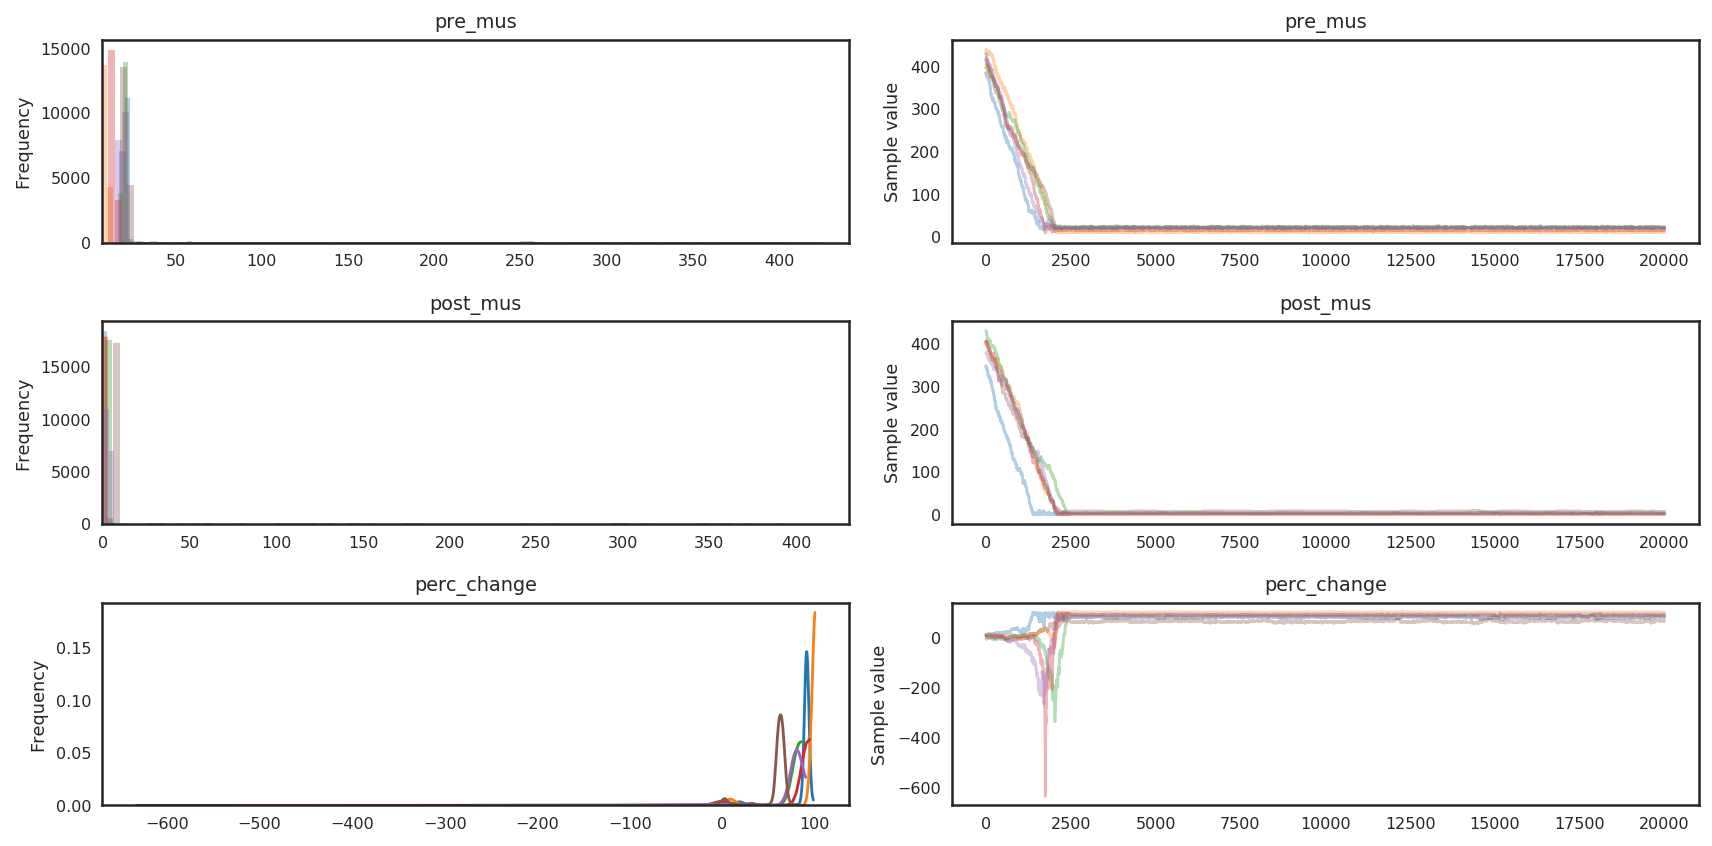

In [19]:
pm.traceplot(trace)

Looking at the trace plots, it's quite clear that convergence with MCMC is reached only after ~2500 steps. To be conservative, we will use only traces from step 5000 onwards.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2878ed0dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f28736801d0>]], dtype=object)

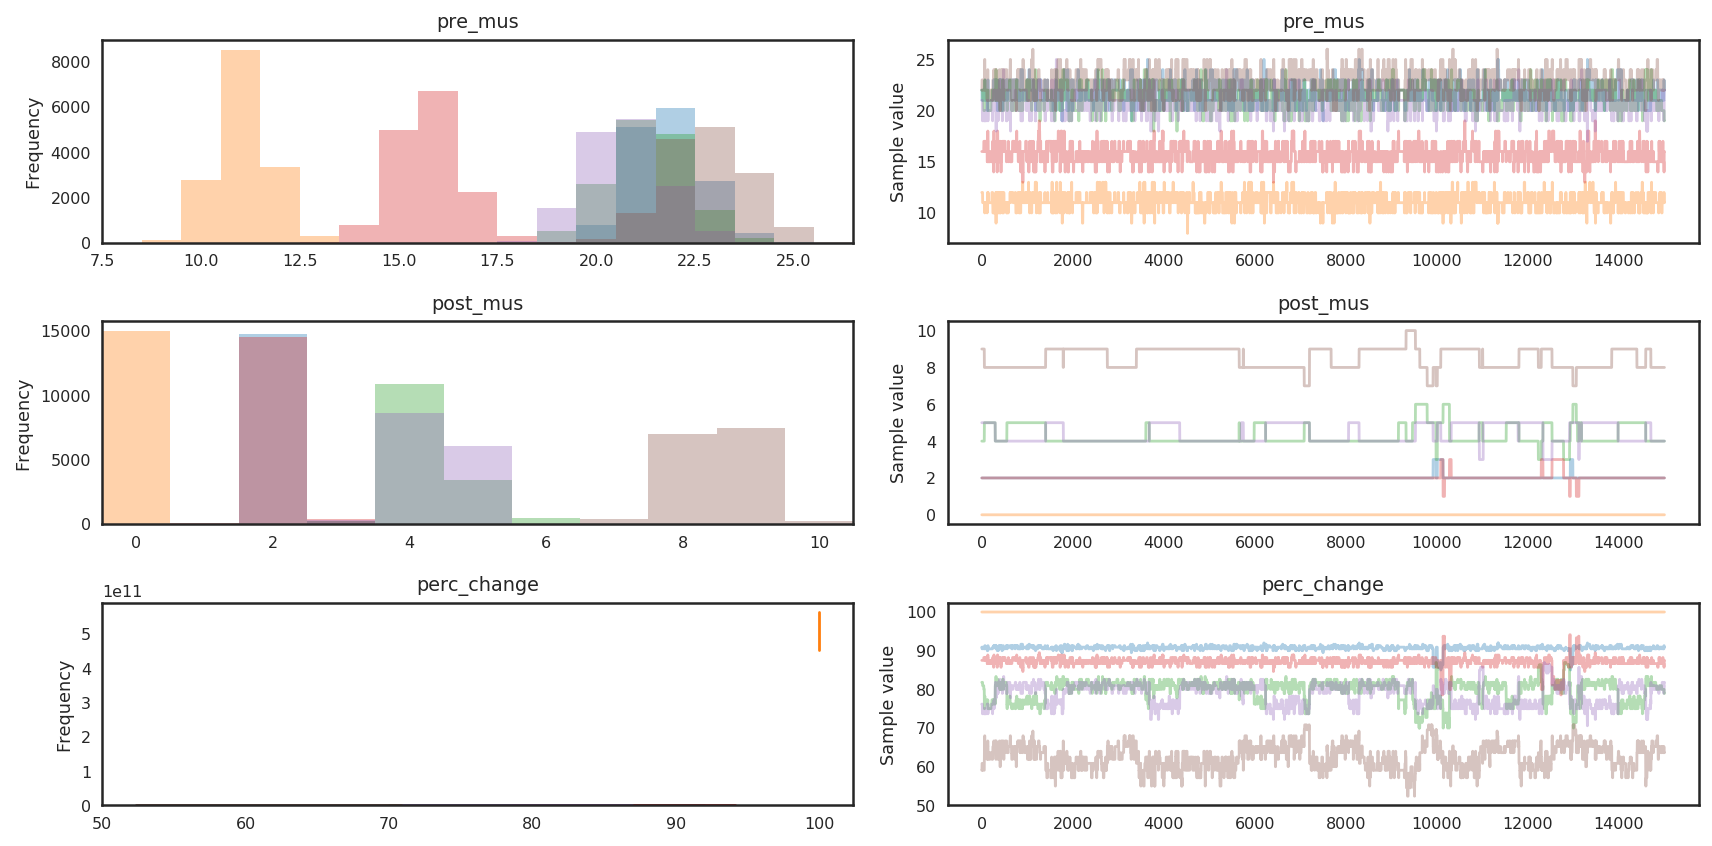

In [20]:
cutoff = 5000
pm.traceplot(trace[cutoff:])

Let's now plot the posterior estimates of the pre-treatment $\mu_{pre}$ and post-treatment $\mu_{post}$ colony counts, and percentage reduction in colony counts $\delta_{p}$.

In [97]:
def get_forestplot_line(ax, kind):
    widths = {'median': 4, 'iqr': 2.0, 'hpd': 1.0}
    assert kind in widths.keys(), f'line kind must be one of {widths.keys()}'
    medians = []
    lines = []
    for child in ax.get_children():
        if isinstance(child, mpl.lines.Line2D):
            if child.get_marker() == 'o' and kind == 'median':
                medians.append(child)
            elif np.allclose(child.get_lw(), widths[kind]):
                lines.append(child)
    if kind == 'median':
        return medians
    else:
        return lines

def adjust_forestplot_for_slides(ax):    
    for line in get_forestplot_line(ax, kind='median'):
        line.set_markersize(10)

    for line in get_forestplot_line(ax, kind='iqr'):
        line.set_linewidth(5)

    for line in get_forestplot_line(ax, kind='hpd'):
        line.set_linewidth(2)
        
    return ax

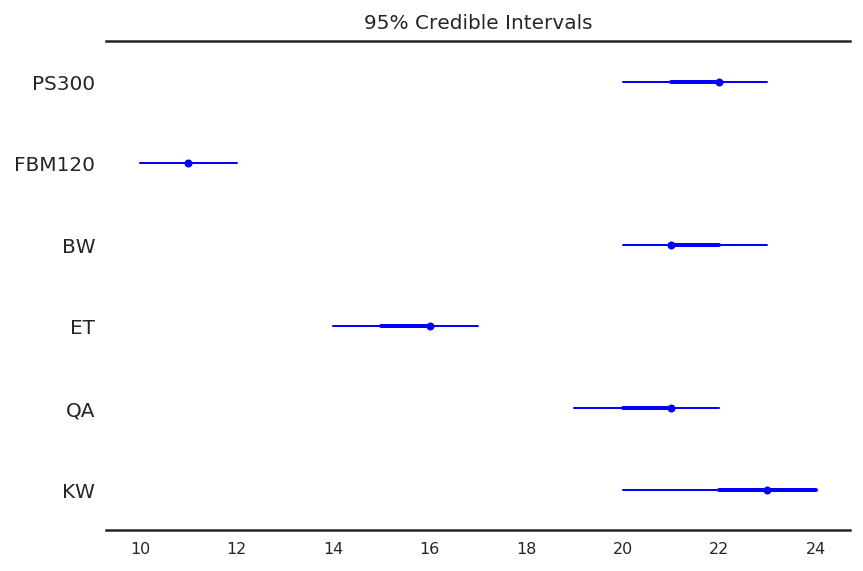

In [98]:
# Plot pre-treatment
pm.forestplot(trace[cutoff:], varnames=['pre_mus'], ylabels=treatment_order)
# ax = plt.gca()
# ax = adjust_forestplot_for_slides(ax)
# plt.show()

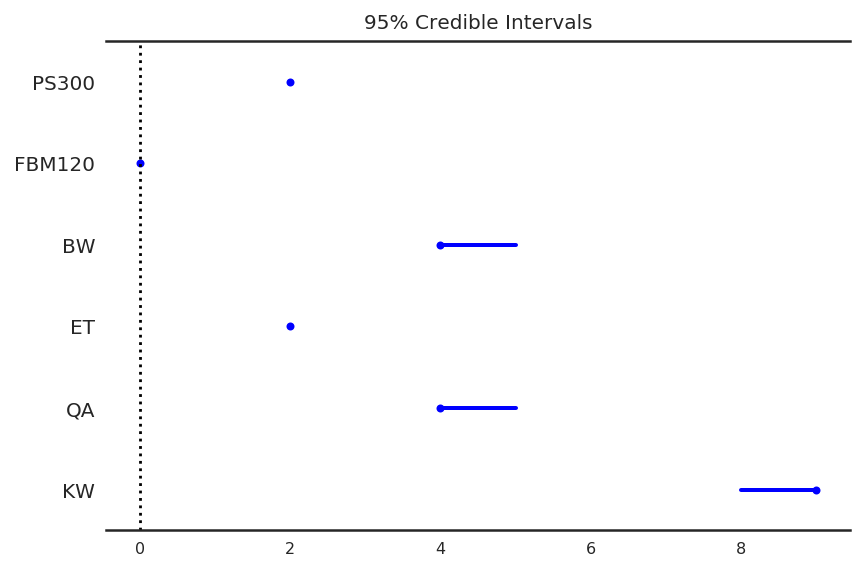

In [99]:
# Plot post-treatment
pm.forestplot(trace[cutoff:], varnames=['post_mus'], ylabels=treatment_order)
# ax = plt.gca()
# ax = adjust_forestplot_for_slides(ax)
# plt.show()

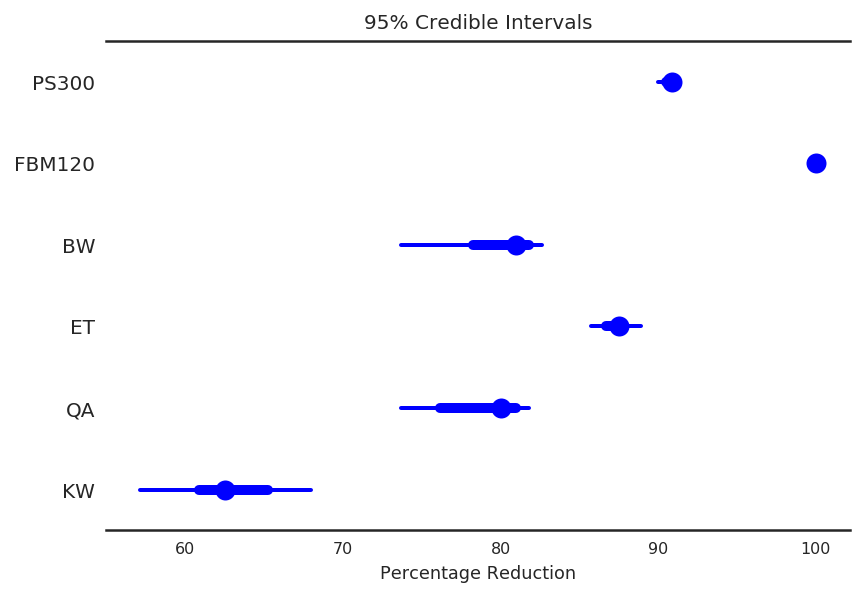

In [101]:
# Plot percentage reduction
pm.forestplot(trace[cutoff:], varnames=['perc_change'], ylabels=treatment_order, xtitle='Percentage Reduction')
ax = plt.gca()
ax = adjust_forestplot_for_slides(ax)
plt.savefig('percentage_reduction.pdf')

The posterior densities show the 95% credible intervals for the amount of sterilization, given the data on hand. From this analysis, it is clear that all of the methods are capable of sterilizing, but FBM_2 gives the most **consistent** sterilization.